<a href="https://colab.research.google.com/github/Sofismarilla/PatientVisitsForecasting/blob/main/fix_multi_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [35]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
%matplotlib inline

from math import sqrt
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from timeit import default_timer as timer

plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['axes.grid'] = False

In [3]:
df = pd.read_csv('/content/drive/MyDrive/THESIS/Dataset/dateset_patient.csv')

In [4]:
train_dates = pd.to_datetime(df['date'])

In [5]:
df.head()

,date,hm,hm_aw,hm_am,cc,cc_aw,cc_am,day_week
0,7/1/2017,66,48,63,44,37,45,6
1,7/2/2017,53,53,62,72,37,43,7
2,7/3/2017,74,54,59,87,42,44,1
3,7/4/2017,87,56,57,58,49,44,2
4,7/5/2017,95,62,58,72,53,44,3


In [8]:
cols = list(df)[4:8]

In [9]:
cols

['cc', 'cc_aw', 'cc_am', 'day_week']

In [10]:
df_for_training = df[cols].astype(float)

In [11]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [55]:
trainX = []
trainY = []

n_future = 90   # Number of days we want to predict into the future
n_past = 30     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))


trainX shape == (1229, 30, 4).
trainY shape == (1229, 1).


In [56]:

model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 
model.add(tf.keras.layers.Dropout(0.5)) 
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               68096     
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 128)               0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 128)               0         
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 1)                 129       
Total params: 68,225
Trainable params: 68,225
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model.fit(trainX, trainY, epochs=50, batch_size=100, validation_split=0.1, verbose=1)

Epoch 1/50
12/12 [==============================] - 3s 121ms/step - loss: 1.0641 - val_loss: 0.7090
Epoch 2/50
12/12 [==============================] - 1s 67ms/step - loss: 0.9904 - val_loss: 0.5220
Epoch 3/50
12/12 [==============================] - 1s 66ms/step - loss: 0.9487 - val_loss: 0.4636
Epoch 4/50
12/12 [==============================] - 1s 66ms/step - loss: 0.8762 - val_loss: 0.3929
Epoch 5/50
12/12 [==============================] - 1s 67ms/step - loss: 0.8154 - val_loss: 0.4620
Epoch 6/50
12/12 [==============================] - 1s 66ms/step - loss: 0.8343 - val_loss: 0.4057
Epoch 7/50
12/12 [==============================] - 1s 67ms/step - loss: 0.7969 - val_loss: 0.5630
Epoch 8/50
12/12 [==============================] - 1s 66ms/step - loss: 0.7857 - val_loss: 0.4356
Epoch 9/50
12/12 [==============================] - 1s 65ms/step - loss: 0.7929 - val_loss: 0.5891
Epoch 10/50
12/12 [==============================] - 1s 67ms/step - loss: 0.7917 - val_loss: 0.3926
Epoch 11

In [58]:
n_future=90  #Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1d').tolist()

In [59]:
forecast = model.predict(trainX[-n_future:]) #forecast 

In [60]:
forecast_copies = np.repeat(forecast, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

In [61]:
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())

In [62]:
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'cc':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['date'])


In [67]:
original = df[['date', 'cc']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2020-7-1']

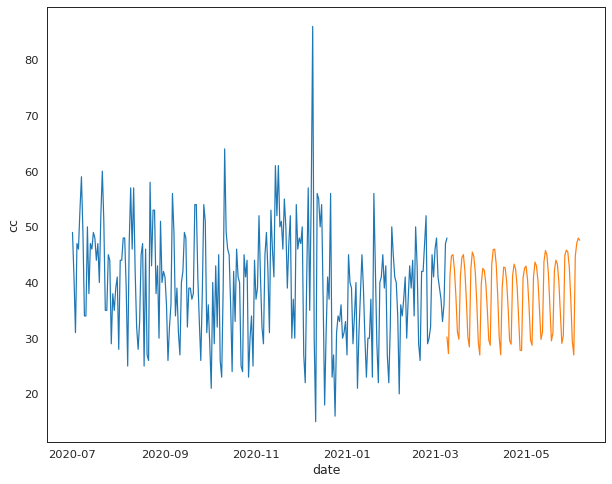

In [68]:
sns.lineplot(original['date'], original['cc'])
sns.lineplot(df_forecast['date'], df_forecast['cc'])

In [77]:
df_forecast

,date,cc,Date
0,2021-03-09,30.2110,2021-03-09
1,2021-03-10,27.2329,2021-03-10
2,2021-03-11,41.2753,2021-03-11
3,2021-03-12,44.7779,2021-03-12
4,2021-03-13,45.0169,2021-03-13
...,...,...,...
85,2021-06-02,26.9916,2021-06-02
86,2021-06-03,44.7200,2021-06-03
87,2021-06-04,47.0591,2021-06-04
88,2021-06-05,47.9815,2021-06-05


In [78]:
df_forecast.to_csv("cc_pv.csv")

In [79]:
baca = pd.read_csv('cc_pv.csv')

In [80]:
baca

,Unnamed: 0,date,cc,Date
0,0,2021-03-09,30.2110,2021-03-09
1,1,2021-03-10,27.2329,2021-03-10
2,2,2021-03-11,41.2753,2021-03-11
3,3,2021-03-12,44.7779,2021-03-12
4,4,2021-03-13,45.0169,2021-03-13
...,...,...,...,...
85,85,2021-06-02,26.9916,2021-06-02
86,86,2021-06-03,44.7200,2021-06-03
87,87,2021-06-04,47.0591,2021-06-04
88,88,2021-06-05,47.9815,2021-06-05
